## Loop to get the Spatial Structure Parameters

In [126]:
using PyCall
using Distributions, Statistics, Distances
using DataFrames
using LightGraphs, SimpleWeightedGraphs
using Random , Printf, Glob

import PyPlot , CSV
import Distances, StatsBase

rootdir = "/home/stephane/Science/cluster/GAIA"

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

## directory
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/plotdens"
ocdir= "$wdir/oc"

cd(wdir)

In [127]:
cd(ocdir)
files= glob("*csv")
cd(wdir)

df = DataFrame(voname= String[], C= Float64[], Cerr= Float64[], s= Float64[], serr= Float64[], m= Float64[],
merr= Float64[])

fitflag= false
for f in files
    if fitflag
        fname= f[1:end-4] ; fvot= f[1:end-7]
        oc= CSV.read("$ocdir/$fname.csv" , delim= ";")
        ocfile= "$ocdir/$fname.csv" ; voname= "$fvot.vot"
        println("## ocfile: $voname")
        println("## fitting the radial profile....")
    
        ntest= 100 ; niter= 30000
    
        ## estimating the binning
        nstar= length(oc.X)
        println("## Nstar: $nstar")
        nbin= min(trunc(Int, nstar/10),20)
        println("## NBIN: $nbin")
    
        θfit, θfiterr, fitfound= spatialParameter(ocfile, ntest, nbin, niter, false)
    
        println("## Fit:")
        println(θfit)
        println(θfiterr)
        println(" ")
    
        push!(df, [voname,θfit.C , θfiterr.C, θfit.s , θfiterr.s, θfit.m , θfiterr.m])
    end
end

if fitflag 
    CSV.write("test-fitCauchy-1.csv", df, delim=";") 
else
    
    println("\n##\n## No fit...\n##")
end


##
## No fit...
##


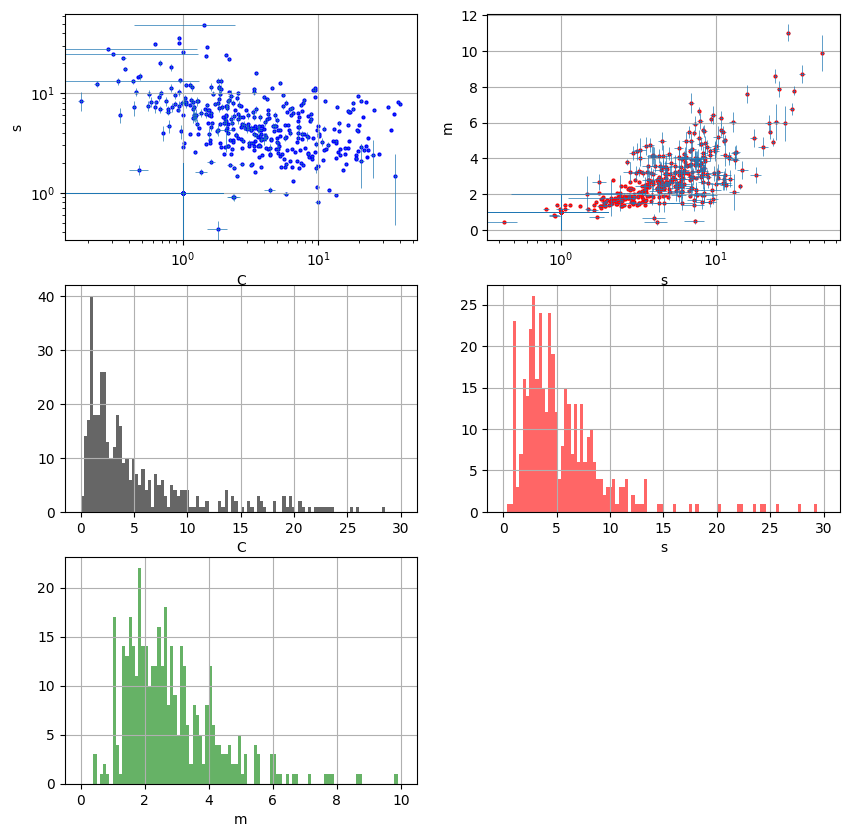

In [128]:
csvfile= "test-fitCauchy.csv"
df= CSV.read(csvfile , delim= ";")


fig= PyPlot.figure(figsize=(10,10))

ax= PyPlot.subplot(321)
PyPlot.grid("on")
ax.set_xscale("log")
ax.set_yscale("log")
PyPlot.xlabel("C")
PyPlot.ylabel("s")
PyPlot.scatter(df.C, df.s , s=4, facecolor="blue" )
PyPlot.errorbar(df.C, df.s, xerr=df.Cerr, yerr=df.serr, linewidth=0.5,ls="none")


ax= PyPlot.subplot(322)
PyPlot.grid("on")
ax.set_xscale("log")
#ax.set_yscale("log")
PyPlot.xlabel("s")
PyPlot.ylabel("m")
PyPlot.scatter(df.s, df.m , s=4, facecolor="red" )
PyPlot.errorbar(df.s, df.m, xerr=df.serr, yerr=df.merr, linewidth=0.5,ls="none")

ax = PyPlot.subplot(323)
PyPlot.grid("on")
nbins = 100
h = PyPlot.hist(df.C,nbins,range = [0,30], color = "k", alpha=0.6 , label = "C")
PyPlot.xlabel("C")

ax = PyPlot.subplot(324)
PyPlot.grid("on")
nbins = 100
h = PyPlot.hist(df.s,nbins,range = [0,30], color = "r", alpha=0.6 , label = "s")
PyPlot.xlabel("s")

ax = PyPlot.subplot(325)
PyPlot.grid("on")
nbins = 100
h = PyPlot.hist(df.m,nbins,range = [0,10], color = "g", alpha=0.6 , label = "s")
PyPlot.xlabel("m")

PyPlot.show()

--------------
## Checking all the fit with data.

Figs saved with data density with Cauchy Fit.

In [129]:
function _plotFitDensityFig(filelist, θlist, ifig, nrow, ncol, ocdir)
    
    fig= PyPlot.figure(figsize=(15,10))
    
    for i in 1:length(filelist)
        ocname= filelist[i][1:end-4]
        θ= θlist[i]
        ocfile= "$ocdir/$ocname-oc.csv"
        _plotDensity(ocfile, θ,nrow, ncol, i, ocname)
    end
    
    figname= "densityOC-$ifig.png"
    PyPlot.savefig(figname)
    PyPlot.close(fig)
end


function _plotDensity(ocfile, θ, irow, icol, nplot, title)
    oc= CSV.read(ocfile, delim= ";")
    # binned density
    nstar= length(oc.X)
    nbin= min(trunc(Int, nstar/10),20)
    r2d,ρ2d,err2d= density2D(oc.Y, oc.Z, nbin)
    ρ2dfit= model_rad(r2d, θ, fdens1)
    
    ax= PyPlot.subplot(irow, icol, nplot)
    ax.set_xlabel("r [pc]")
    ax.set_ylabel("ρ")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlim(r2d[1]*0.9, r2d[end]*1.1)
    ax.set_ylim(minimum(ρ2d[ρ2d .> 0])*0.3,maximum(ρ2d)*1.5)
    PyPlot.grid("on")
    PyPlot.scatter(r2d, ρ2d , s=4, facecolor="blue" )
    PyPlot.errorbar(r2d, ρ2d, yerr=2 .* err2d, linewidth=0.5)
    PyPlot.plot(r2d, ρ2dfit, "k-", linewidth=1)
    
    ## TEXT
    ax.text(0.02, 0.01, title, verticalalignment= "bottom" , horizontalalignment="left",
        transform=ax.transAxes, color="green", fontsize=15)
    
    val=θ.C ; txt= @sprintf("C= %3.3f",val)
    ax.text(0.02, 0.2, txt, verticalalignment= "bottom" , horizontalalignment="left",
        transform=ax.transAxes, color="red", fontsize=12)
    val=θ.s ; txt= @sprintf("s= %3.3f [pc]",val)
    ax.text(0.02, 0.3, txt, verticalalignment= "bottom" , horizontalalignment="left",
        transform=ax.transAxes, color="red", fontsize=12) 
    val=θ.m ; txt= @sprintf("m= %3.3f",val)
    ax.text(0.02, 0.4, txt, verticalalignment= "bottom" , horizontalalignment="left",
        transform=ax.transAxes, color="red", fontsize=12)
    
    val= nstar ; txt= @sprintf("Nstar= %d",val)
    ax.text(0.02, 0.52, txt, verticalalignment= "bottom" , horizontalalignment="left",
        transform=ax.transAxes, color="blue", fontsize=12)
    
end

_plotDensity (generic function with 2 methods)

In [130]:
cd(plotdir)

rowperfig= 4
colperfig= 3
plotperfig= rowperfig*colperfig

ifig= 1
plotaccum=0
filevot= [] ; θlist= [] ; θerrlist= []
for item in 1:length(df.voname)
    push!(filevot, df.voname[item])
    θ= GaiaClustering.modelCauchy(df.C[item], df.s[item], df.m[item])
    push!(θlist, θ)
    θerr= GaiaClustering.modelCauchy(df.Cerr[item], df.serr[item], df.merr[item])
    push!(θerrlist, θerr)
    plotaccum += 1
    
    if plotaccum == plotperfig
        _plotFitDensityFig(filevot, θlist, ifig,rowperfig, colperfig , ocdir)
        println("## Fig $ifig done.")
        filevot= [] ; θlist= [] ; θerrlist= []
        plotaccum= 0 ; ifig += 1

    end
end

cd(wdir)

## Fig 1 done.
## Fig 2 done.
## Fig 3 done.
## Fig 4 done.
## Fig 5 done.
## Fig 6 done.
## Fig 7 done.
## Fig 8 done.
## Fig 9 done.
## Fig 10 done.
## Fig 11 done.
## Fig 12 done.
## Fig 13 done.
## Fig 14 done.
## Fig 15 done.
## Fig 16 done.
## Fig 17 done.
## Fig 18 done.
## Fig 19 done.
## Fig 20 done.
## Fig 21 done.
## Fig 22 done.
## Fig 23 done.
## Fig 24 done.
## Fig 25 done.
## Fig 26 done.
## Fig 27 done.
## Fig 28 done.
## Fig 29 done.
## Fig 30 done.
## Fig 31 done.
## Fig 32 done.
## Fig 33 done.
